In [504]:
import pandas as pd
import ast as ast
import numpy as np
from typing import *
import seaborn as sns
import matplotlib.pyplot as plt
from task_2_helpers import *
from transformers import pipeline

### Data Read

In [505]:
# df_business = pd.read_parquet('data/ATML2024_businesses.parquet')
df_business = pd.read_csv('data/ATML2024_businesses.csv', header=0)

# df_Train_reviews = pd.read_parquet('data/ATML2024_reviews_train.parquet')
df_Train_reviews = pd.read_csv('data/ATML2024_reviews_train.csv', header=0)

# df_users = pd.read_parquet('data/ATML2024_users.parquet')
#df_users = pd.read_csv('data/ATML2024_users.csv', header=0, nrows=100)

### Cleanup business data columns

In [506]:
# @@@@ Run only once
# Keep only observation business in Philadelphia
bussiness_city = ['Phila','Philadelphia', 'Philadelphia', 'Philadelphia (Northeast Philly)', 'Philadelphia PA', 'Philadelphila', 'Philadephia', 'Philiadelphia', 
'Philiidelphia', 'Philly', 'Southwest Philadelphia', 'West Philadelphia', 'philadelphia', 'PHILA', 'PHILADELPHIA']
df_business = df_business[df_business['city'].isin(bussiness_city)]
df_business = df_business[df_business['state'] == 'PA']

# Convert dictionary columns to the correct types
df_business['attributes'] = df_business['attributes'].apply(lambda x: ast.literal_eval(x) if not pd.isna(x) or not pd.isnull(x)  else dict())
df_business['hours'] = df_business['hours'].apply(lambda x: ast.literal_eval(x) if not pd.isna(x) or not pd.isnull(x)  else dict())

# Extract values from dictionary columns
df_business['hours_list'] = df_business['hours'].apply(lambda x: extract_hours_value(x))
df_business['attributes_list'] = df_business['attributes'].apply(lambda x: sorted(extract_attributes_value(x)))
df_business['categories_list'] = df_business['categories'].apply(lambda x: sorted(map(lambda a: a.strip().lower(),  x.split(',')) ) if isinstance(x, str) else [])

# Join Business Data With Ratings Data
df_business_data = df_business[['business_id', 'postal_code', 'attributes_list', 'hours_list', 'categories_list']]
df_ratings_data = df_Train_reviews[['business_id', 'rating', 'useful', 'funny', 'cool', 'text']]

In [507]:
df_data = pd.merge(df_business_data, df_ratings_data, left_on= 'business_id', right_on='business_id')

# Keep only values with "restaurants"
df_data = df_data[df_data['categories_list'].apply(lambda x: any('restaurants' in str(a).lower() for a in x))]

#### Applying sentiment analysis on reviews

In [508]:
# Load NLP models
classifier = pipeline('zero-shot-classification', model="facebook/bart-large-mnli") # TO DO: find a better model
sent_pipe = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

c:\Users\Alexis\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBartForSequenceClassification: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing TFBartForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBartForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBartForS

In [509]:
# Find quantity of reviews with more 375 tokens
df_data['token'] = df_data['text'].apply(lambda x: len(x.split(" ")))
df_data[df_data["token"] >= 375].shape[0] / df_data.shape[0]
df_data["token"].describe()

# Split the dataset up to 3 parts of 125 tokens each
df_1 = df_data[(df_data['token'] >= 1) & (df_data['token'] <= 125)]
df_2 = df_data[(df_data['token'] >= 126) & (df_data['token'] <= 250)]
df_3 = df_data[(df_data['token'] >= 251) & (df_data['token'] <= 375)]

# Write in new columns the tokens
df_2['token_1'] = df_2['text'].apply(lambda x: ' '.join(x.split()[:125]))
df_2['token_2'] = df_2['text'].apply(lambda x: ' '.join(x.split()[125:250]))

df_3['token_1'] = df_3['text'].apply(lambda x: ' '.join(x.split()[:125]))
df_3['token_2'] = df_3['text'].apply(lambda x: ' '.join(x.split()[125:250]))
df_3['token_3'] = df_3['text'].apply(lambda x: ' '.join(x.split()[250:375]))

C:\Users\Alexis\AppData\Local\Temp\ipykernel_9824\850704694.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['token_1'] = df_2['text'].apply(lambda x: ' '.join(x.split()[:125]))
C:\Users\Alexis\AppData\Local\Temp\ipykernel_9824\850704694.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['token_2'] = df_2['text'].apply(lambda x: ' '.join(x.split()[125:250]))
C:\Users\Alexis\AppData\Local\Temp\ipykernel_9824\850704694.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [510]:
# To do: removed 
df_1 = df_1[:620]
df_2 = df_2[:620]
df_3 = df_3[:620]

# To do: Move to Helper
def sentiment(text):
    output = sent_pipe(text)[0]['label']
    return output

# Assign sentiments based on reviews 
df_1['sentiment'] = df_1['text'].apply(sentiment)
df_2["sentiment_1"] = df_2['token_1'].apply(sentiment)
df_2["sentiment_2"] = df_2['token_2'].apply(sentiment)
df_3["sentiment_1"] = df_3['token_1'].apply(sentiment)
df_3["sentiment_2"] = df_3['token_2'].apply(sentiment)
df_3["sentiment_3"] = df_3['token_3'].apply(sentiment)

# Extract the final sentiment (voted)
df_2["sentiment"] = df_2[['sentiment_1', 'sentiment_2']].mode(axis=1)[0]
df_3["sentiment"] = df_3[['sentiment_1', 'sentiment_2','sentiment_3']].mode(axis=1)[0]

# Drop columns
df_2 = df_2.drop(columns=['token_1', 'sentiment_1', 'token_2', 'sentiment_2'])
df_3 = df_3.drop(columns=['token_1', 'sentiment_1', 'token_2', 'sentiment_2','token_3', 'sentiment_3'])

# Unify the datasets
df_data = pd.concat([df_1, df_2, df_3], ignore_index=True)
df_data.head()

,business_id,postal_code,attributes_list,hours_list,categories_list,rating,useful,funny,cool,text,token,sentiment
0,wm9eoqjytVbC7dQcM4WSTM,19107,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",5,0,0,0,I love this place.. I love their chunky fried...,44,POSITIVE
1,wm9eoqjytVbC7dQcM4WSTM,19107,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",5,0,0,1,I ordered so many cake from here for our famil...,29,POSITIVE
2,wm9eoqjytVbC7dQcM4WSTM,19107,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",5,1,0,0,This is my favorite bakery in Chinatown! It's ...,93,POSITIVE
3,wm9eoqjytVbC7dQcM4WSTM,19107,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",4,2,2,2,I am quite partial to the St Honore in Mei Foo...,49,POSITIVE
4,wm9eoqjytVbC7dQcM4WSTM,19107,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",4,1,0,0,my friends and i were on the search for the be...,55,POSITIVE


Since models are often limited to 128 tokens, we circumvent this problem by applying sentiment analysis several times. To do this, we separate the text into slices of 125 tokens and apply a voting system to extract a final sentiment.

## 2.1  An insight on what restaurant consumers generally seem to like (for example in terms of food, service, location, etc...).

## Insights based on logical metrics (ratings and distribution)

In [511]:
# All categories in a set
all_categories = set(np.concatenate(df_data.categories_list.values).ravel()) #df_data.categories_list.values.flatten()

# Replace list by unique element. (individualize /create new rows)
categories_individ_df = df_data.explode('categories_list')
categories_individ_df = categories_individ_df[categories_individ_df['categories_list'] != 'restaurants']
categories_individ_df = categories_individ_df[categories_individ_df['categories_list'] != 'food']

# TO DO: Define the groups we will keep
group_names = ["Ambiance", "Location", "Service Style", "Meal Type", "Type of Cuisine" ]
#all_categories = {"wine", "sandwiches", "bakeries","japanese"} # TO BE REMOVED ( we will use all_categories from above)

# Define group
CategoryLabel = {}

# Assign a group to categories
for category in all_categories:
    output = classifier(category, group_names)
    CategoryLabel[category] = output['labels'][0]

CategoryLabel

# Mapping the group to the categories
categories_individ_df["group_categorie"] = categories_individ_df["categories_list"].map(CategoryLabel)

We use a classification model to assign each category a broader group name. 

#### Frequency of items in Attributes

In [512]:
# See the distribution of ratings in Philadelphia
# TO DO : Should decide on the threshold for the ratings.
categories_individ_df["rating"].describe()

count    7275.000000
mean        3.763436
std         1.276351
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

C:\Users\Alexis\AppData\Local\Temp\ipykernel_9824\3712709394.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='categories_list', y='rating', data=mean_ratings, palette='viridis')


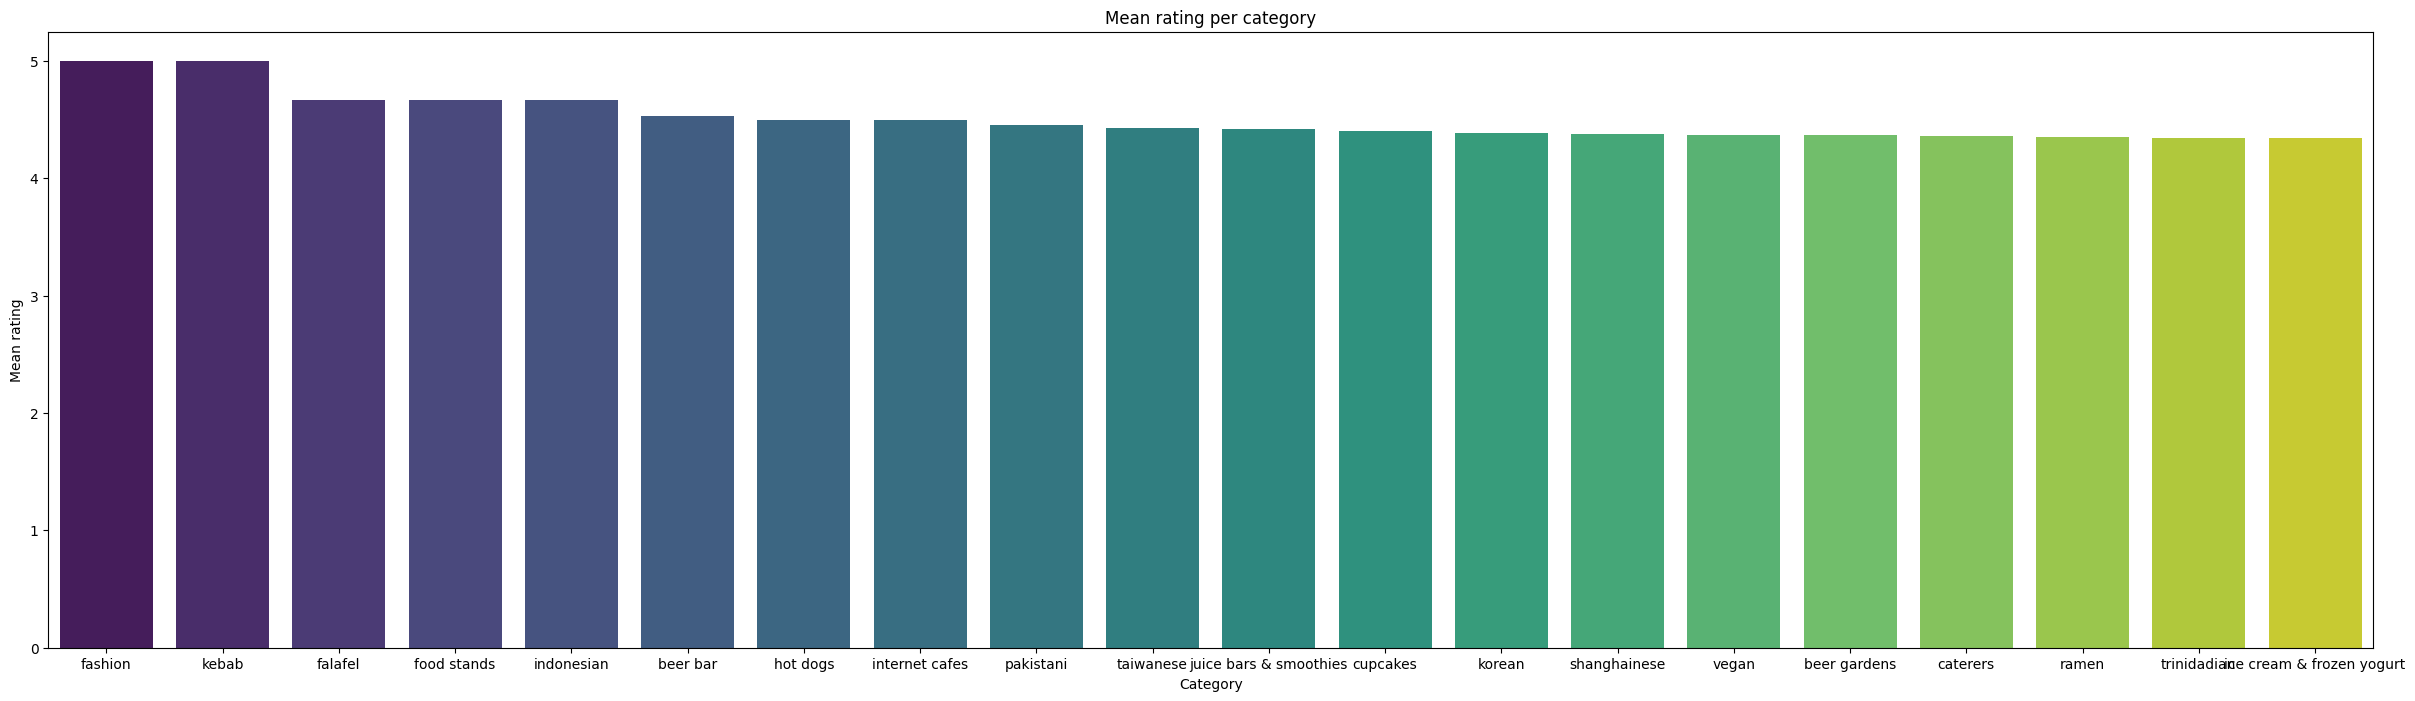

C:\Users\Alexis\AppData\Local\Temp\ipykernel_9824\3712709394.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category', y='percentage', data=category_perct_df, palette='viridis')


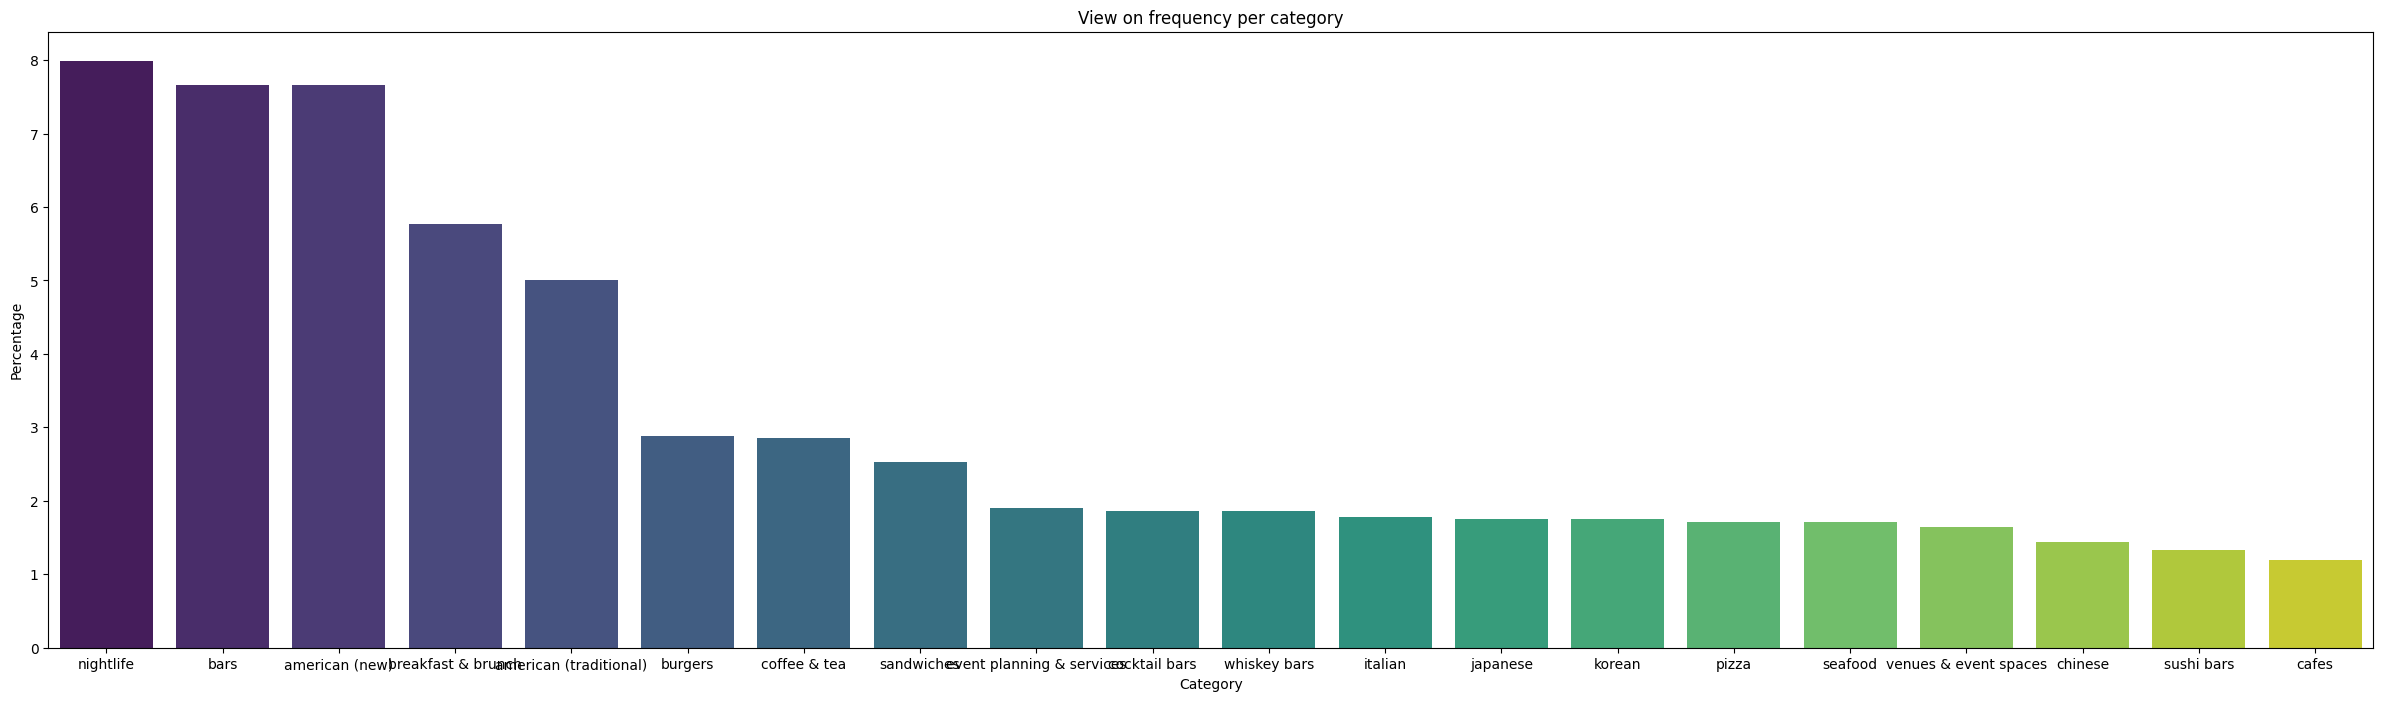

In [524]:
############################################################
# Averaging the ratings per category

# Plot
mean_ratings = categories_individ_df.groupby('categories_list')['rating'].mean().reset_index()
mean_ratings = mean_ratings.sort_values(by='rating', ascending=False)[:20]
plt.figure(figsize=(30, 8))
plt.title('Mean rating per category')
sns.barplot(x='categories_list', y='rating', data=mean_ratings, palette='viridis')
plt.xlabel('Category')
plt.ylabel('Mean rating')
plt.show()

############################################################
# Percentage per category
category_counts = categories_individ_df['categories_list'].value_counts()
category_percent = (category_counts / category_counts.sum()) * 100

# Plot
category_perct_df = category_percent.reset_index()[:20]
category_perct_df.columns = ['category', 'percentage']
plt.figure(figsize=(30, 8))
plt.title('View on frequency per category')
sns.barplot(x='category', y='percentage', data=category_perct_df, palette='viridis')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.show()

#### PLOT PER GROUP CATEGORY

In [525]:
# Mean rating per category
mean_ratings["group_category"] = mean_ratings["categories_list"].map(CategoryLabel)
mean_ratings = mean_ratings.groupby(['group_category', 'categories_list'])['rating'].mean().reset_index()
mean_ratings

,group_category,categories_list,rating
0,Ambiance,fashion,5.000000
1,Ambiance,trinidadian,4.344828
2,Location,beer gardens,4.366667
3,Location,internet cafes,4.500000
4,Meal Type,beer bar,4.529412
5,Meal Type,cupcakes,4.400000
6,Meal Type,falafel,4.666667
7,Meal Type,hot dogs,4.500000
8,Meal Type,ice cream & frozen yogurt,4.341463
9,Meal Type,juice bars & smoothies,4.421053


C:\Users\Alexis\AppData\Local\Temp\ipykernel_9824\3466879554.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='categories_list', y='rating', data=df_ft, palette='viridis')


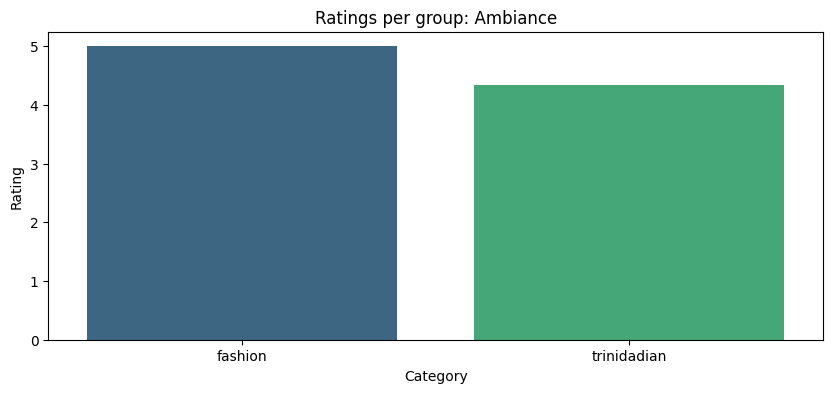

C:\Users\Alexis\AppData\Local\Temp\ipykernel_9824\3466879554.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='categories_list', y='rating', data=df_ft, palette='viridis')


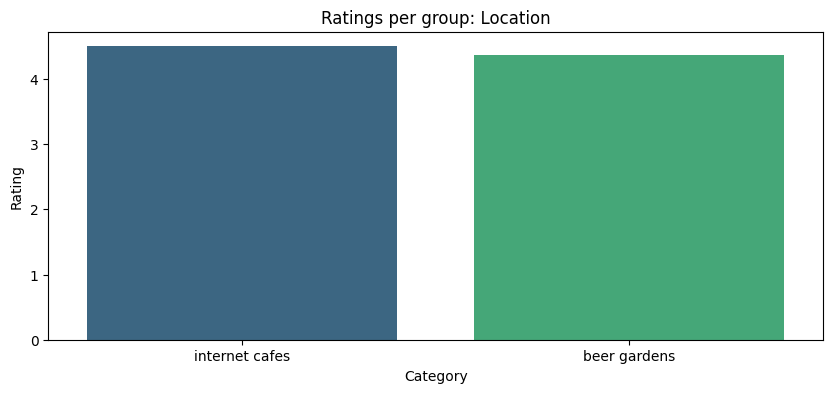

C:\Users\Alexis\AppData\Local\Temp\ipykernel_9824\3466879554.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='categories_list', y='rating', data=df_ft, palette='viridis')


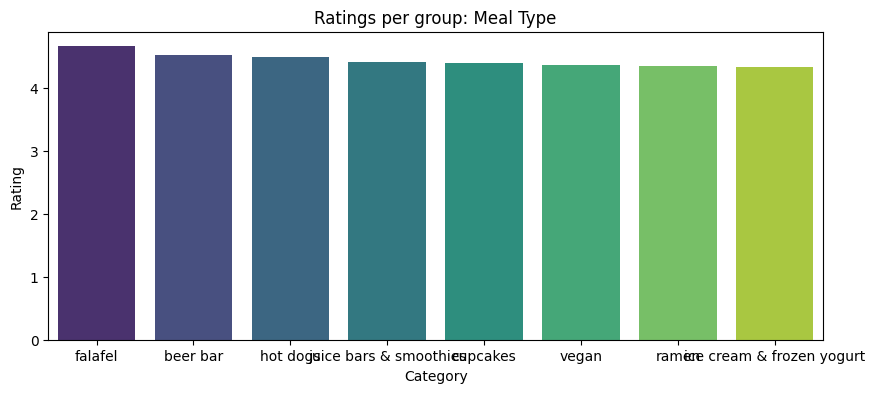

C:\Users\Alexis\AppData\Local\Temp\ipykernel_9824\3466879554.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='categories_list', y='rating', data=df_ft, palette='viridis')


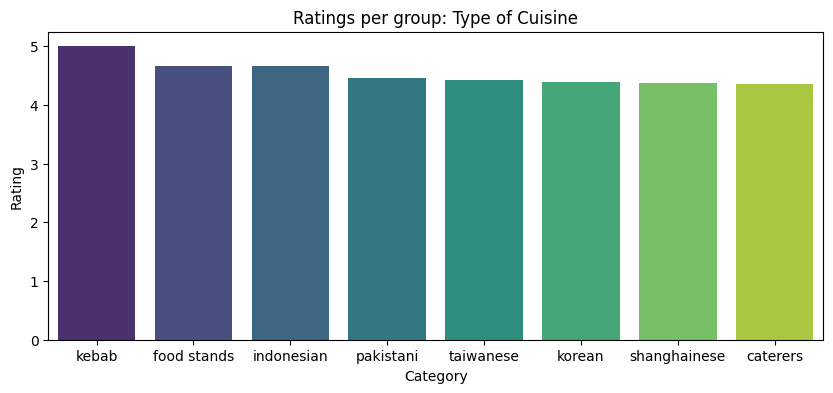

,group_category,categories_list,rating
15,Type of Cuisine,kebab,5.000000
13,Type of Cuisine,food stands,4.666667
14,Type of Cuisine,indonesian,4.666667
17,Type of Cuisine,pakistani,4.457143
19,Type of Cuisine,taiwanese,4.428571
16,Type of Cuisine,korean,4.385827
18,Type of Cuisine,shanghainese,4.375000
12,Type of Cuisine,caterers,4.357143
6,Meal Type,falafel,4.666667
4,Meal Type,beer bar,4.529412


In [526]:
# Bar plots per group
for group in mean_ratings['group_category'].unique():
    df_ft = mean_ratings[mean_ratings['group_category'] == group]
    df_ft[['categories_list', 'rating']]
    df_ft = df_ft.sort_values(by=['rating'], ascending=False)

    plt.figure(figsize=(10, 4))
    plt.title(f'Ratings per group: {group}')
    sns.barplot(x='categories_list', y='rating', data=df_ft, palette='viridis')
    plt.xlabel('Category')
    plt.ylabel('Rating')
    plt.show()
    
mean_ratings[mean_ratings['rating'] >= 4].sort_values(by=['group_category','rating', ], ascending=[False, False])

#### Replicating steps aboven keeping reviews with utility  >= 2

C:\Users\Alexis\AppData\Local\Temp\ipykernel_9824\2921835646.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='categories_list', y='rating', data=mean_ratings, palette='viridis')


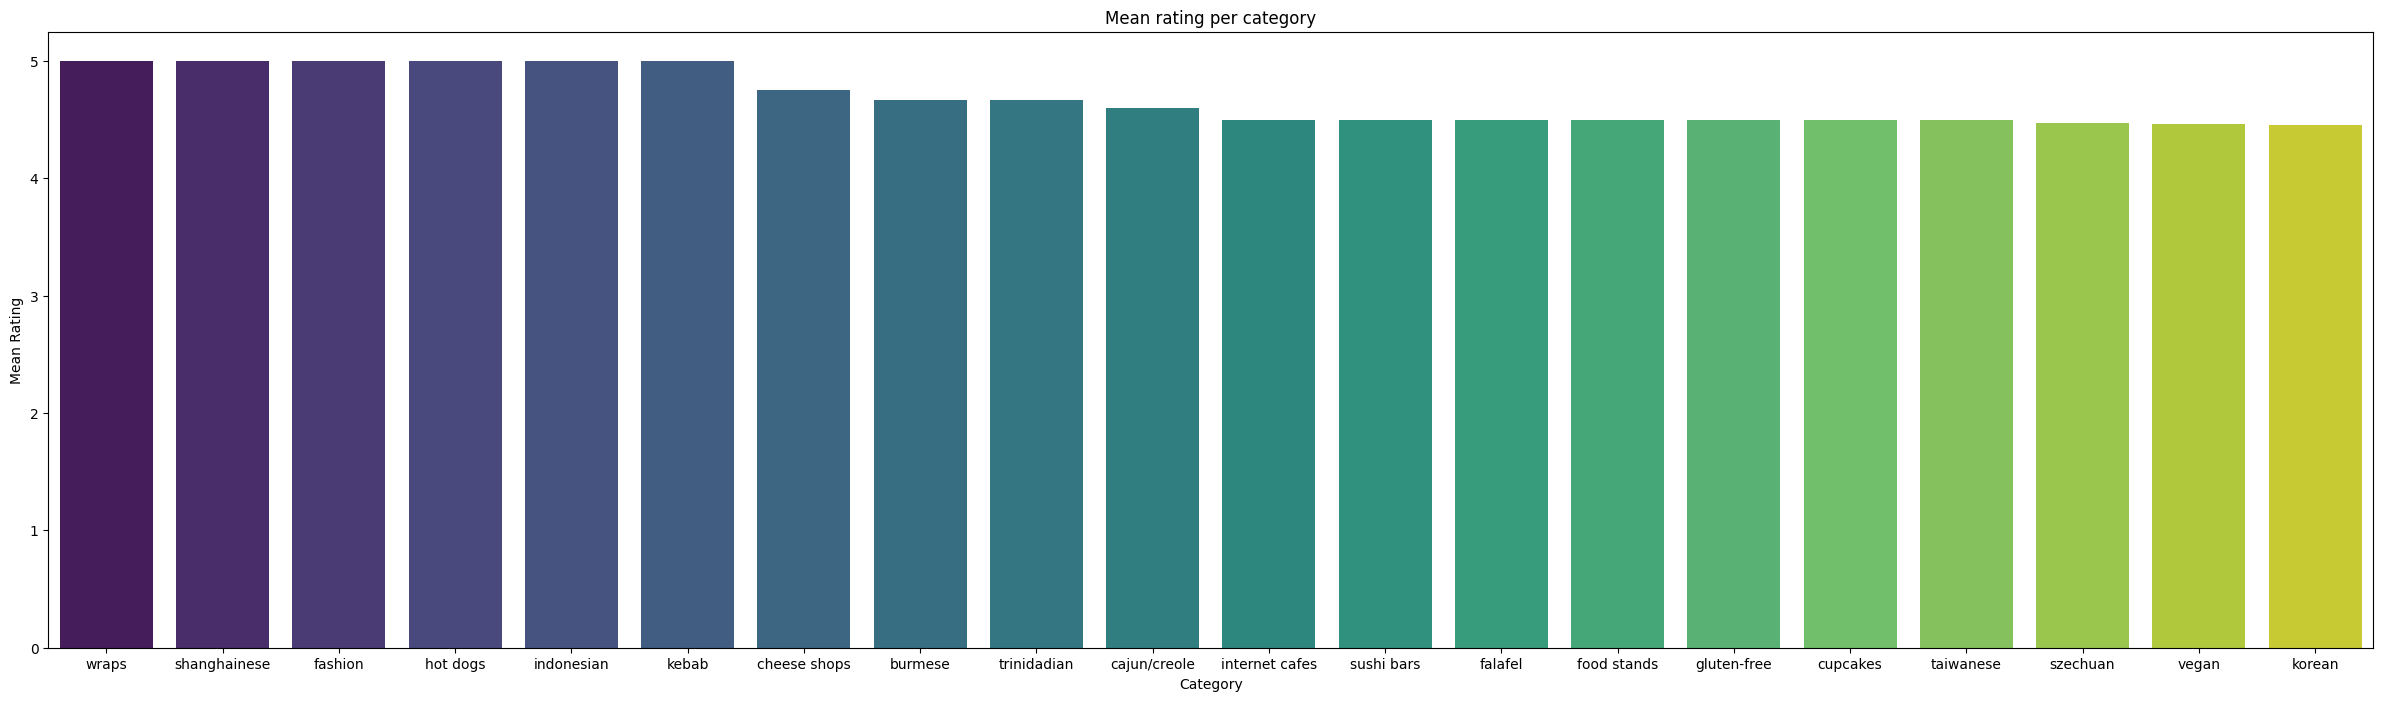

C:\Users\Alexis\AppData\Local\Temp\ipykernel_9824\2921835646.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category', y='percentage', data=category_perct_df, palette='viridis')


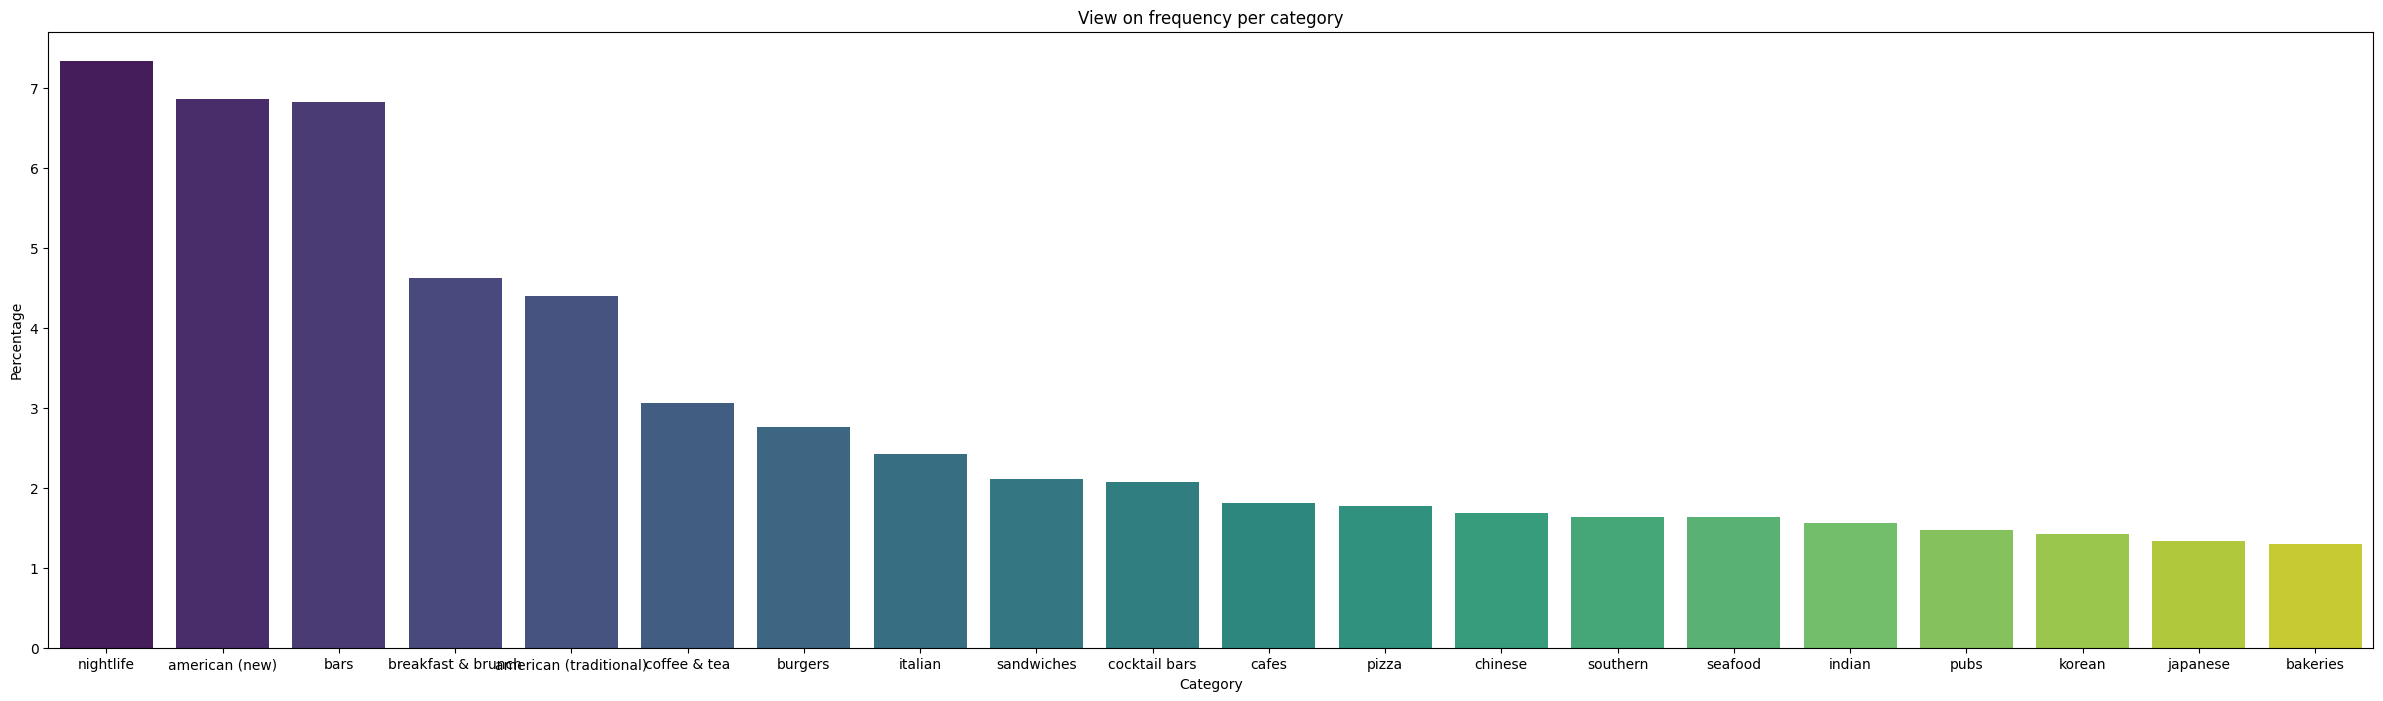

In [527]:
# Keep score in useful >= 2
df_data_utility = categories_individ_df[categories_individ_df['useful'] >= 2]

# Percentage
category_counts = df_data_utility['categories_list'].value_counts()
category_percent = (category_counts / category_counts.sum()) * 100


# Plot
mean_ratings = df_data_utility.groupby('categories_list')['rating'].mean().reset_index()
mean_ratings = mean_ratings.sort_values(by='rating', ascending=False)[:20]
plt.figure(figsize=(30, 8))
plt.title('Mean rating per category')
sns.barplot(x='categories_list', y='rating', data=mean_ratings, palette='viridis')
plt.xlabel('Category')
plt.ylabel('Mean Rating')
plt.show()


# Plot
category_perct_df = category_percent.reset_index()[:20]
category_perct_df.columns = ['category', 'percentage']
plt.figure(figsize=(30, 8))
sns.barplot(x='category', y='percentage', data=category_perct_df, palette='viridis')
plt.title('View on frequency per category')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.show()

The ranking changes when we filter the comments to keep only those useful. We can play with the importance assigned to some reviews by assigning a threshold value to their usefulness. This makes it possible to filter by keeping reviews important to the public opinion.

### Analyzing Atributes

In [546]:
# Reinitializing the dataset
df_data = df_data_full.copy()
attribute_individ_df = df_data.explode('attributes_list')
attribute_counts = attribute_individ_df['attributes_list'].value_counts()
attribute_counts


# Put attributes in a set
all_attributes = set(np.concatenate(df_data.attributes_list.values).ravel()) #df_data.categories_list.values.flatten()
df_data.attributes_list.values
all_attributes

# Group attributes  
                                                                                # TO DO: DEFINE THE GROUPS !
group_names = ["Pricing", "Service Style", "Location", "Beverage", "Meal Times", "Amenities"]
all_attributes = {"NoiseLevel", "BusinessAcceptsCreditCards", "BusinessParking","RestaurantsTakeOut"}
Attribute_groups = {}

# Classify the attributes according to the groups
for category in all_attributes:
    output = classifier(category, group_names)
    Attribute_groups[category] = output['labels'][0]

attribute_individ_df["group_attribute"] = attribute_individ_df["attributes_list"].map(Attribute_groups)

#### Frequency of items in attributes

C:\Users\Alexis\AppData\Local\Temp\ipykernel_9824\2561550540.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='attributes_list', y='rating', data=mean_ratings[:20], palette='viridis')


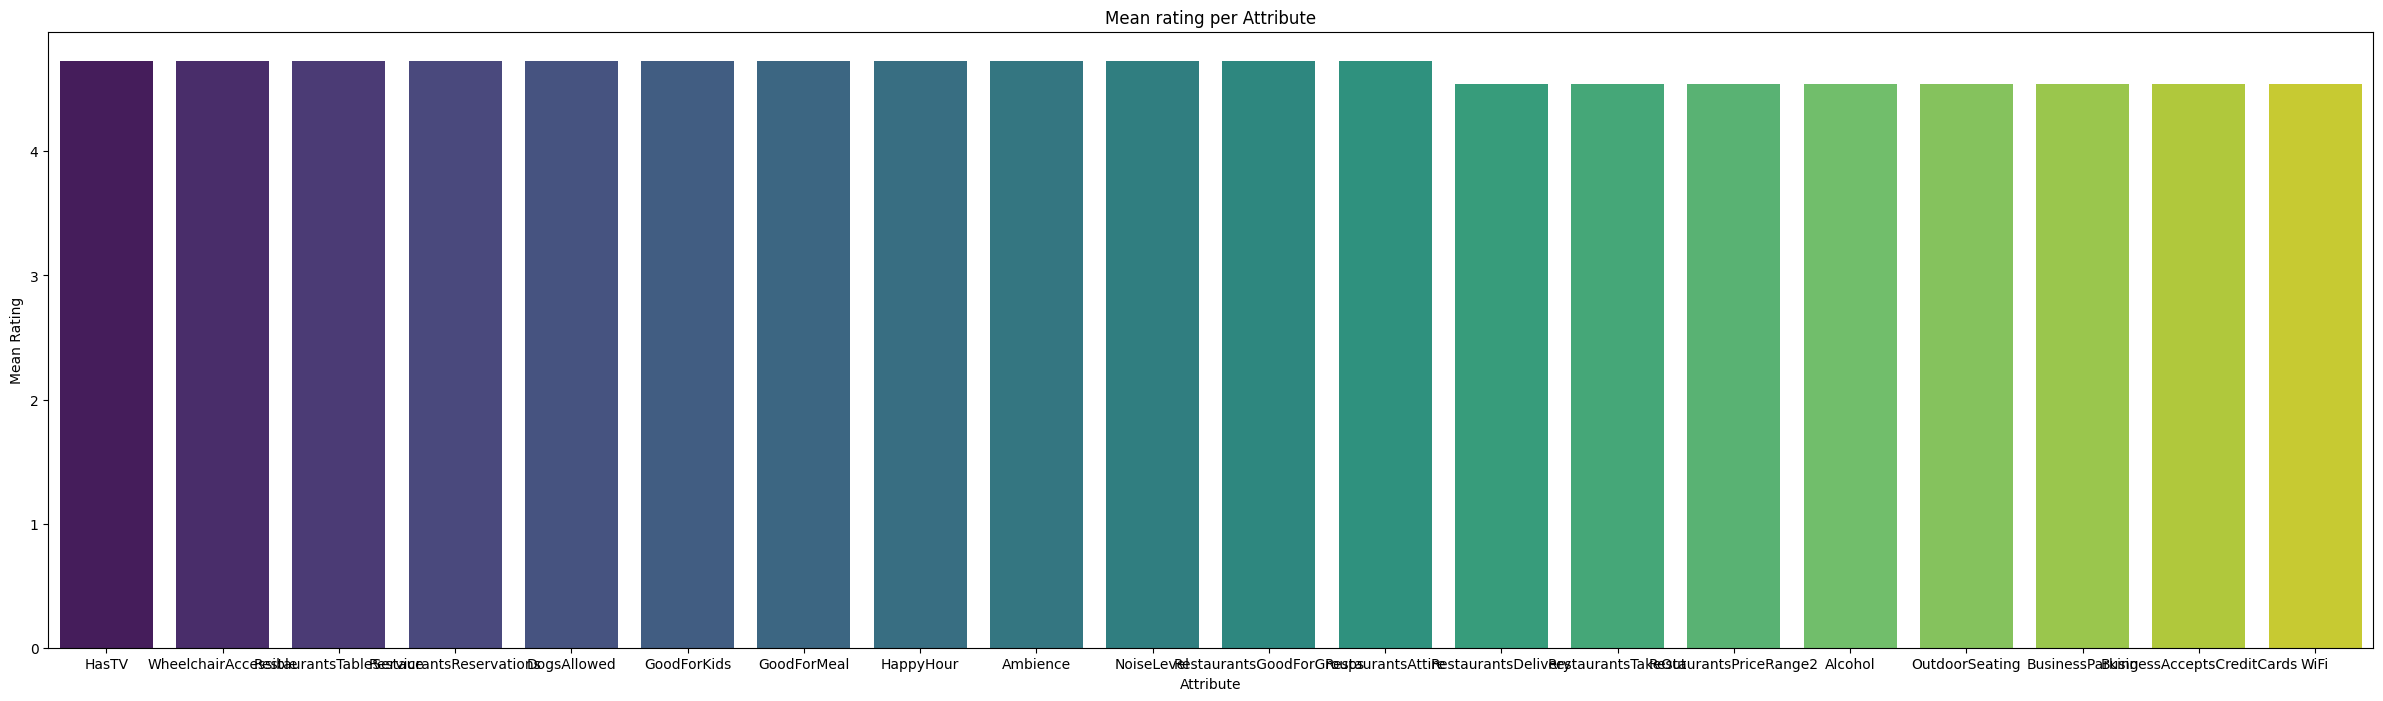

C:\Users\Alexis\AppData\Local\Temp\ipykernel_9824\2561550540.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='attributes', y='percentage', data=attribute_percentages_df[:20], palette='viridis')


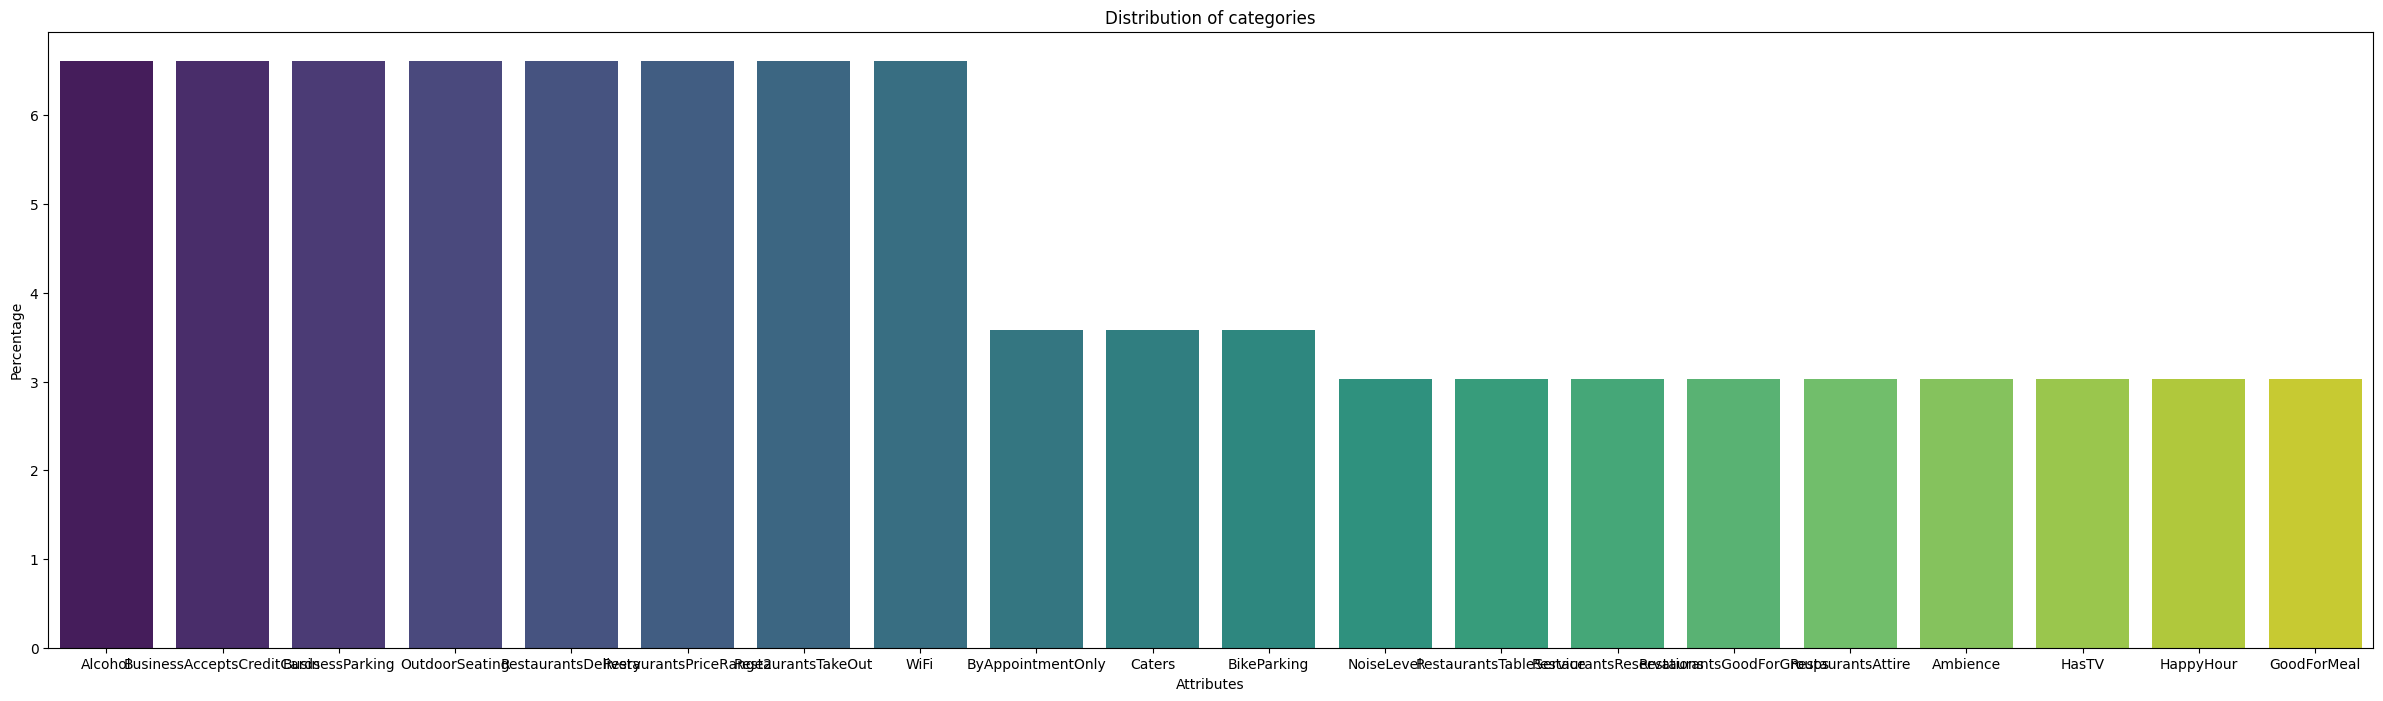

In [539]:
##################################################################
# AVERAING PER CATEGORY

# Plot the results
mean_ratings = attribute_individ_df.groupby('attributes_list')['rating'].mean().reset_index()
mean_ratings = mean_ratings.sort_values(by='rating', ascending=False)
plt.figure(figsize=(30, 8))
plt.title('Mean rating per Attribute')
sns.barplot(x='attributes_list', y='rating', data=mean_ratings[:20], palette='viridis')
plt.xlabel('Attribute')
plt.ylabel('Mean Rating')
plt.show()


##################################################################
# Calculate the percentage distribution
attribute_percentages = (attribute_counts / attribute_counts.sum()) * 100

# Plot the results
attribute_percentages_df = attribute_percentages.reset_index()
attribute_percentages_df.columns = ['attributes', 'percentage']
plt.figure(figsize=(30, 8))
plt.title('Distribution of categories')
sns.barplot(x='attributes', y='percentage', data=attribute_percentages_df[:20], palette='viridis')
plt.xlabel('Attributes')
plt.ylabel('Percentage')
plt.show()

#### Average rating per category

C:\Users\Alexis\AppData\Local\Temp\ipykernel_9824\3312688470.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='attributes_list', y='rating', data=mean_ratings[:20], palette='viridis')


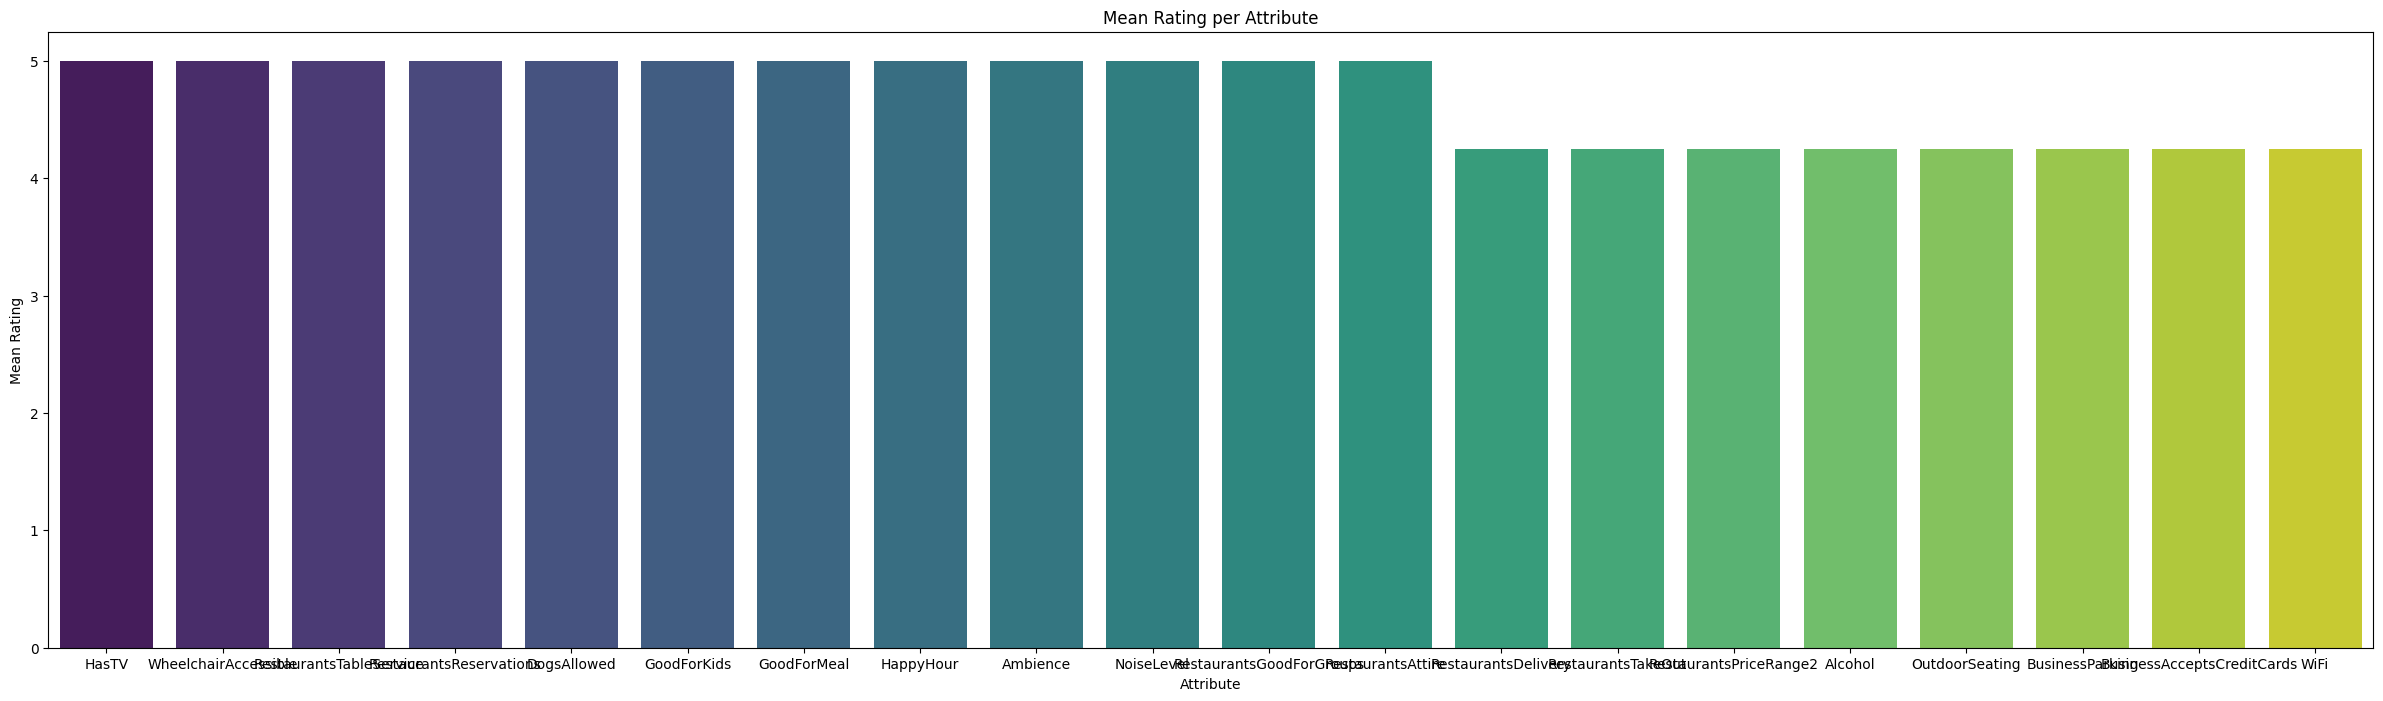

C:\Users\Alexis\AppData\Local\Temp\ipykernel_9824\3312688470.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='attribute', y='percentage', data=attribute_percentages_df[:20], palette='viridis')


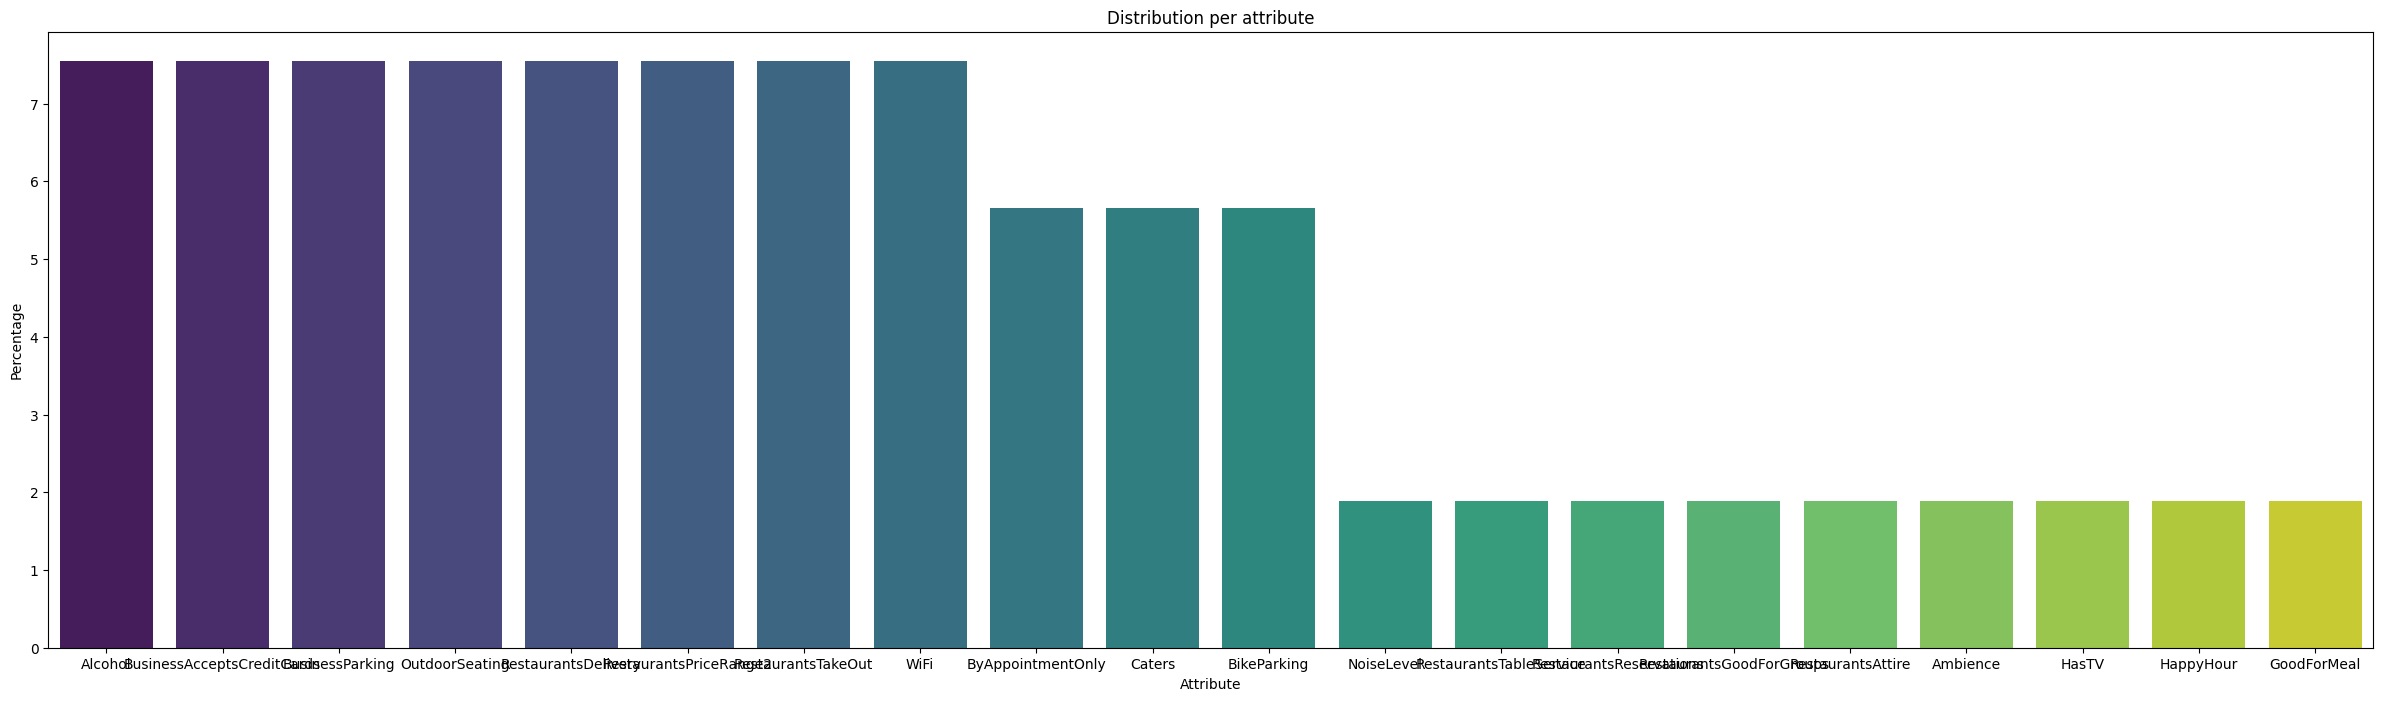

In [536]:
# Keep utility score >= 2
df_data_utility = attribute_individ_df[attribute_individ_df['useful'] >= 2]
attribute_counts = df_data_utility['attributes_list'].value_counts()
attribute_percentages = (attribute_counts / attribute_counts.sum()) * 100

# Plot RATING
mean_ratings = df_data_utility.groupby('attributes_list')['rating'].mean().reset_index()
mean_ratings = mean_ratings.sort_values(by='rating', ascending=False)
plt.figure(figsize=(30, 8))
plt.title('Mean Rating per Attribute')
sns.barplot(x='attributes_list', y='rating', data=mean_ratings[:20], palette='viridis')
plt.xlabel('Attribute')
plt.ylabel('Mean Rating')
plt.show()


# Plot FREQUENCY
attribute_percentages_df = attribute_percentages.reset_index()
attribute_percentages_df.columns = ['attribute', 'percentage']
plt.figure(figsize=(30, 8))
plt.title('Distribution per attribute')
sns.barplot(x='attribute', y='percentage', data=attribute_percentages_df[:20], palette='viridis')
plt.xlabel('Attribute')
plt.ylabel('Percentage')
plt.show()

#### PLOT PER GROUP ATTRIBUTE

In [554]:
# Mean rating per category
mean_ratings["group_attribute"] = mean_ratings["attributes_list"].map(Attribute_groups)
mean_ratings = mean_ratings.groupby(['group_attribute', 'attributes_list'])['rating'].mean().reset_index()
mean_ratings

,group_attribute,attributes_list,rating
0,Location,BusinessParking,4.541667
1,Service Style,BusinessAcceptsCreditCards,4.541667
2,Service Style,NoiseLevel,4.727273
3,Service Style,RestaurantsTakeOut,4.541667


C:\Users\Alexis\AppData\Local\Temp\ipykernel_9824\704294645.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='attributes_list', y='rating', data=df_filt, palette='viridis')


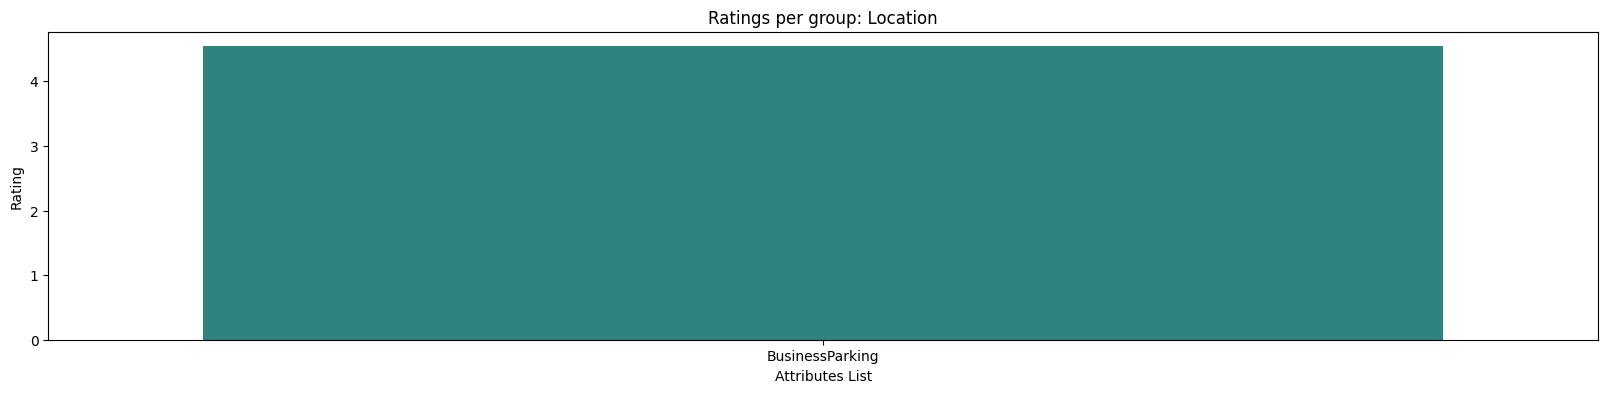

C:\Users\Alexis\AppData\Local\Temp\ipykernel_9824\704294645.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='attributes_list', y='rating', data=df_filt, palette='viridis')


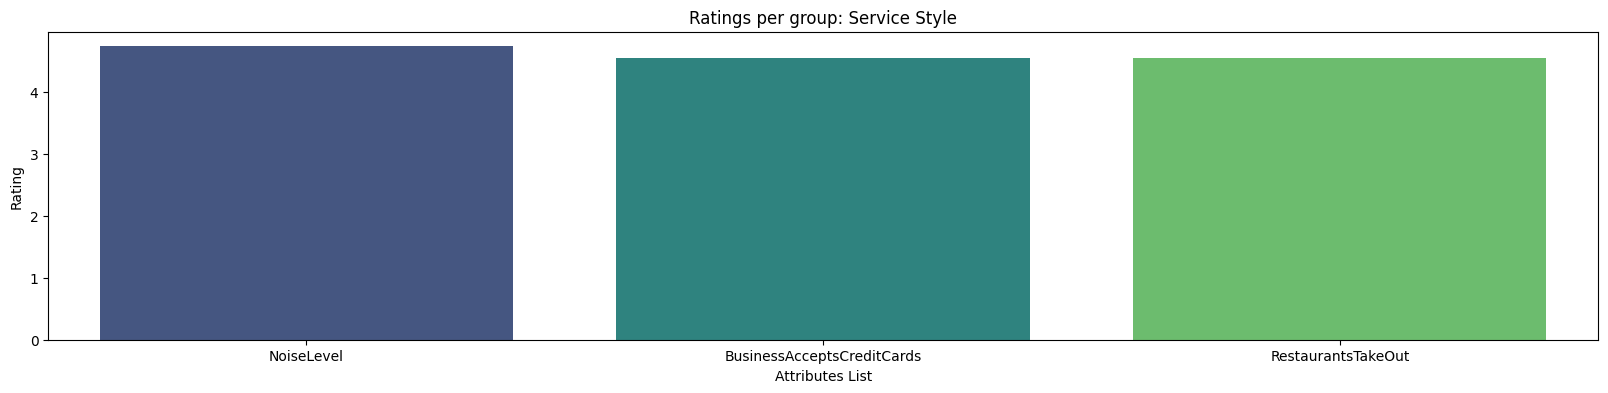

In [555]:

# Barplots per attribute
for group in mean_ratings['group_attribute'].unique():
    df_filt = mean_ratings[mean_ratings['group_attribute'] == group]
    df_filt[['attributes_list', 'rating']]
    df_filt = df_filt.sort_values(by=['rating'], ascending=False)

    plt.figure(figsize=(20, 4))
    plt.title(f'Ratings per group: {group}')
    sns.barplot(x='attributes_list', y='rating', data=df_filt, palette='viridis')
    plt.xlabel('Attributes List')
    plt.ylabel('Rating')
    plt.show()

## Insights based on sentiments

In [571]:
# Compute a mean per category
categories_individ_df["sentiment"] = categories_individ_df["sentiment"].replace("NEGATIVE", 0)
categories_individ_df["sentiment"] = categories_individ_df["sentiment"].replace("POSITIVE", 1)
mean_sent_category = categories_individ_df.groupby(['group_categorie', 'categories_list'])['sentiment'].mean().reset_index()
mean_sent_category.sort_values(by='sentiment', ascending=False)


,group_categorie,categories_list,sentiment
110,Type of Cuisine,dive bars,1.0
16,Ambiance,poke,1.0
68,Meal Type,hot dogs,1.0
1,Ambiance,african,1.0
76,Meal Type,seafood markets,1.0
...,...,...,...
7,Ambiance,beverage store,0.0
11,Ambiance,fashion,0.0
112,Type of Cuisine,food delivery services,0.0
15,Ambiance,piano bars,0.0


C:\Users\Alexis\AppData\Local\Temp\ipykernel_9824\3454256611.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='categories_list', y='sentiment', data=df_filt[:20], palette='viridis')


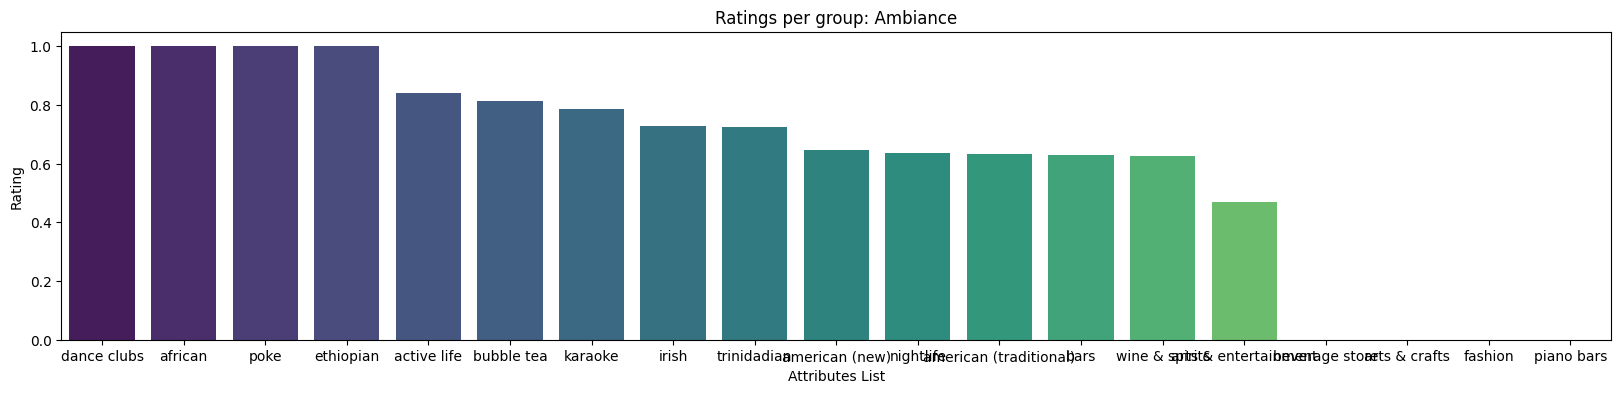

C:\Users\Alexis\AppData\Local\Temp\ipykernel_9824\3454256611.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='categories_list', y='sentiment', data=df_filt[:20], palette='viridis')


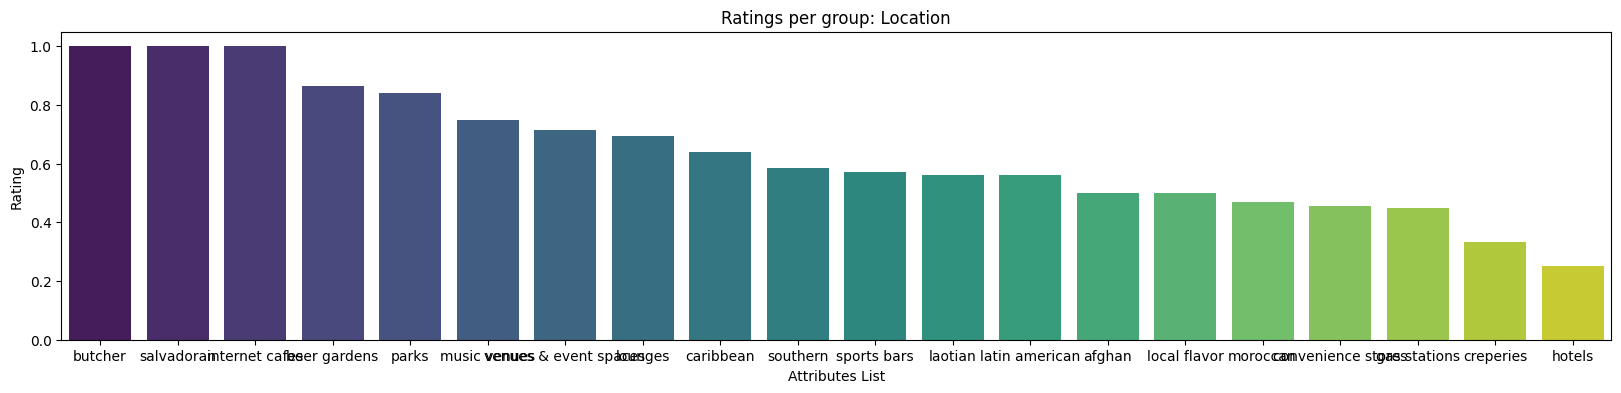

C:\Users\Alexis\AppData\Local\Temp\ipykernel_9824\3454256611.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='categories_list', y='sentiment', data=df_filt[:20], palette='viridis')


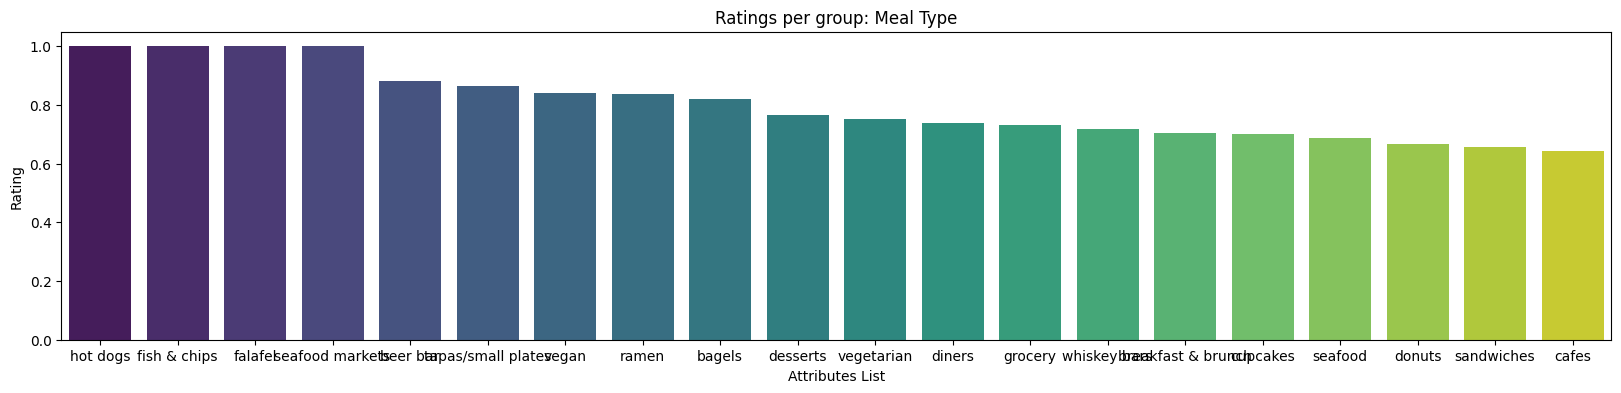

C:\Users\Alexis\AppData\Local\Temp\ipykernel_9824\3454256611.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='categories_list', y='sentiment', data=df_filt[:20], palette='viridis')


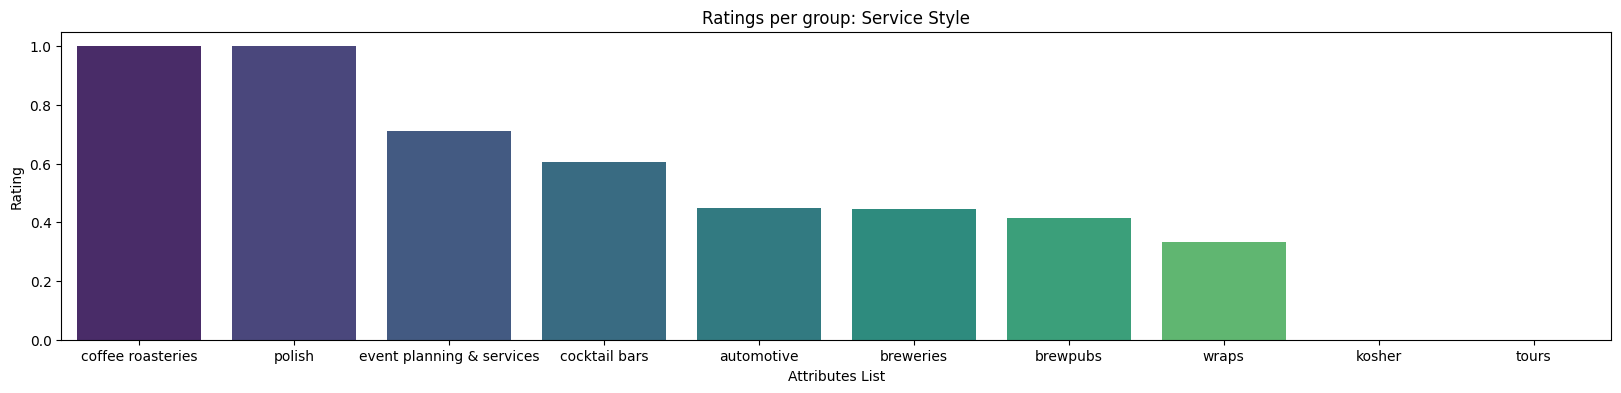

C:\Users\Alexis\AppData\Local\Temp\ipykernel_9824\3454256611.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='categories_list', y='sentiment', data=df_filt[:20], palette='viridis')


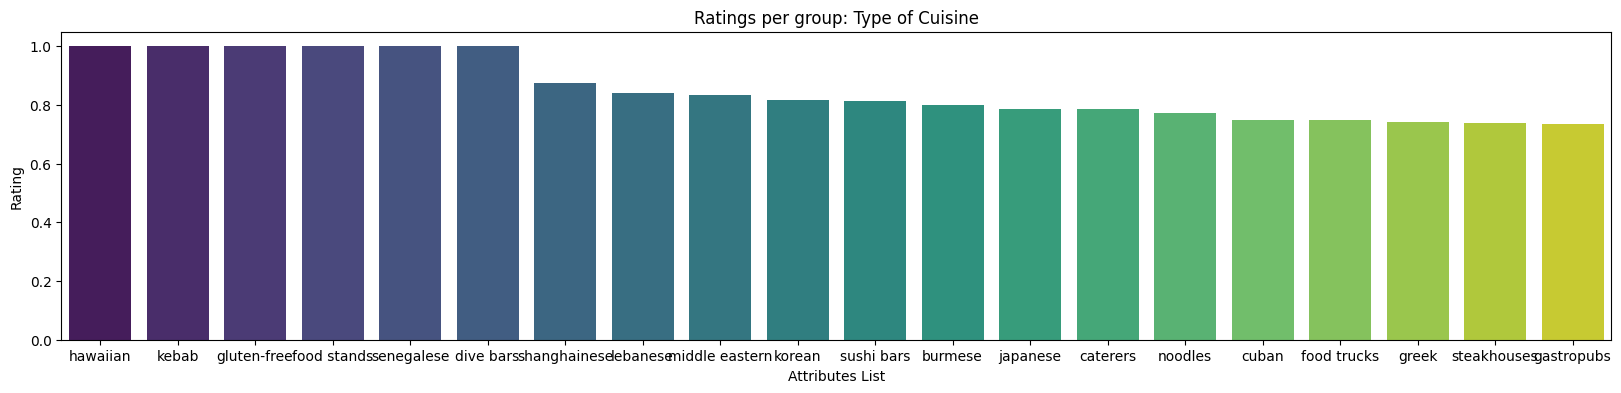

In [574]:
# Barplots per category and sentiment
for group in mean_sent_category['group_categorie'].unique():
    df_filt = mean_sent_category[mean_sent_category['group_categorie'] == group]
    df_filt[['categories_list', 'sentiment']]
    df_filt = df_filt.sort_values(by=['sentiment'], ascending=False)

    plt.figure(figsize=(20, 4))
    plt.title(f'Ratings per group: {group}')
    sns.barplot(x='categories_list', y='sentiment', data=df_filt[:20], palette='viridis')
    plt.xlabel('Attributes List')
    plt.ylabel('Rating')
    plt.show()

In [566]:
categories_individ_df.head()
attribute_individ_df


# Compute a mean per attribute
attribute_individ_df["sentiment"] = attribute_individ_df["sentiment"].replace("NEGATIVE", 0)
attribute_individ_df["sentiment"] = attribute_individ_df["sentiment"].replace("POSITIVE", 1)
mean_sent_attribute = attribute_individ_df.groupby(['group_attribute', 'attributes_list'])['sentiment'].mean().reset_index()
mean_sent_attribute

,group_attribute,attributes_list,sentiment
0,Location,BusinessParking,1.0
1,Service Style,BusinessAcceptsCreditCards,1.0
2,Service Style,NoiseLevel,1.0
3,Service Style,RestaurantsTakeOut,1.0


En vue d'extraire le maximum d'information de notre data set nous souhaitons tirer profit de la variable "useful". Ainsi, notre hypothèse est qu'une personne qui administre un vote "useful" a un commentaire le trouve pertinent de l'une ou l'autre manière. Soit elle n'a pas encore visité le restaurant et donc elle a appris quelquechose d'utile, soit elle l'a visité et pense de manière similaire à ce commentaire. De ce fait, cela est un indicateur de qualité que nous souhaitons mettre en avant. 

In the analysis above, we sought to explore insights in the datasets targeted at Philadelphia using NLP methods and statistical calculations. Our approach is based on a quantitative and qualitative view of reviews linked to "attributes" and "categories" by business. This gives us an appreciative idea of the importance of different ratings. As the problem seeks to discover what is liked by consumers, we refined our analysis to consider only reviews classified as positive. We continued by groupping the categories and attributes by factors (groups) to get a more precise view of similar variables in our analysis. 

Next, we ...

# 2.2
## An analysis of the evolution of food trends in the area over time, in terms of consumer preferences. Do the preferences evolve over time, or do they seem stable?

# 2.3
## Imagine you have to present your findings to the business owner and his investors. What advice would you give to the new business, based on your findings?

### TO DO: Find the most frequent and worse ratings ( negative feeling) per attribute and category. 

We can interpret negativity as frustration and unfulfilled needs. As a result, there's a chance to be successful in the restaurant business by satisfying unfulfilled needs, and consequently to do good business. To maximize your chances of success, you need to target what most consumers are saying. That's why we need to identify what is particularly misjudged in Philadelphia.

Our analysis has shown that the Philadelphia restaurant market: [Findings]...
1. General across years
2. Trend analysis + evolution
    1. What is stable VS unstable ?
    2. What is recent ?

We recommend to the business owner and his investors: [Practically / Business insight]